### Imports & Display Options

In [1]:
%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 100

In [2]:
from matplotlib import pylab

In [113]:
import numpy as np
import feather
import re
from datetime import datetime
from itertools import cycle

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc

In [5]:
from keras.utils import np_utils
from keras.layers import LSTM, Convolution1D, Flatten, Dropout, Dense, GlobalMaxPooling1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.regularizers import l2
from keras.callbacks import TensorBoard, Callback

Using TensorFlow backend.


### Import Data & Clean

In [ ]:
df = pd.read_csv('./BasicCompanyDataAsOneFile-2018-03-01.csv')
df.head()

In [ ]:
def clean(df):
    wdf = df.dropna(subset=['Returns.LastMadeUpDate'])
    wdf = wdf[['CompanyName', 'SICCode.SicText_1']]
    wdf['CompanyName'] = wdf.CompanyName.str.replace('[".,()\-\']', ' ')\
        .str.replace('\s+', ' ').str.strip()\
        .str.replace('LIMITED', 'LTD')\
        .str.replace('INCORPORATED', 'INC')\
        .str.replace('([A-Z])LTD', '\\1 LTD')\
        .str.replace('(LTD|INC|PLC)', '')\
        .str.replace('\\b[A-Z0-9]\\b', '')
    wdf['SICC'] = SICC = wdf['SICCode.SicText_1'].str.split(' - ').str[0]
    wdf = wdf[(SICC != '74990') & (SICC != '99999') & (SICC != '7499') & SICC.str.isnumeric()]
    wdf = wdf[wdf.CompanyName.str.count(' ') < 8]
    return wdf

In [ ]:
wdf = clean(df)
len(wdf)

### Remove Unknown Names

In [34]:
wdf['WordSum'] = wdf.CompanyName.str.replace('[0-9]', '').apply(sum_of_custom_tokenize)
(wdf.WordSum == 0).sum()

2310

In [35]:
# Remove super short names
(wdf.CompanyName.str.len() < 4).sum()

0

In [36]:
wdf[wdf.WordSum == 0].head(25)

,CompanyName,SICC,WordSum,Industry,SICText,OrigIndustry
313,006 PUBCO,56302,0,563,56302 - Public houses and bars,563
454,12 DOLLSHOUSES,47650,0,476,47650 - Retail sale of games and toys in speci...,476
1184,16 MINIBUSES/MVL,49390,0,493,49390 - Other passenger land transport,493
1276,40 WAMLA,98000,0,980,98000 - Residents property management,980
1813,10 THE WALDRONS,98000,0,980,98000 - Residents property management,980
1961,100 BODYCARE,96090,0,9609,96090 - Other service activities n.e.c.,960
1963,100 BROADST,68209,0,682,68209 - Other letting and operating of own or ...,682
2224,101 ROKFORM,41202,0,412,41202 - Construction of domestic buildings,412
2578,1066 ROLLERDANCE,93290,0,932,93290 - Other amusement and recreation activit...,932
2598,107 FORTUNESWELL,68209,0,682,68209 - Other letting and operating of own or ...,682


In [37]:
wdf = wdf[(wdf.WordSum > 0) & (wdf.CompanyName.str.len() > 3) & (wdf.SICC.str.len() == 5)]
len(wdf)

2110207

In [22]:
# Remove company names that are all numbers
wdf = wdf[~wdf.CompanyName.str.match('^[0-9\\s]+$')]
len(wdf)

### Feature Engineering

In [ ]:
wdf['Industry'] = wdf['SICCode.SicText_1'].str.split(' - ').str[0].str[0:3]
wdf['SICText'] = wdf['SICCode.SicText_1']
wdf = wdf.drop('SICCode.SicText_1', axis=1)
wdf.head()

In [15]:
# Copy industry column, as it will be modified
wdf['OrigIndustry'] = wdf['Industry']

In [47]:
hard_to_classify_set = {"829", "479", "960", "329", "461", "464", "639", "289", "642", "661"}
def merge_split_classes(value):
    if value[:3] in hard_to_classify_set:
        return value[:4]
    else:
        return value[:3]

In [48]:
# Split some hard to classify classes out
wdf['Industry'] = wdf.SICC.apply(merge_split_classes)

In [49]:
# These class is not possible to predict, a bunch of misc.
wdf = wdf[wdf.Industry != '8299']  # Other business activities (n.e.c)
print(len(wdf))
wdf = wdf[wdf.Industry != '9609']  # Other service activities (n.e.c)
print(len(wdf))
wdf = wdf[wdf.Industry != '4618']  # Sales of other products
print(len(wdf))
wdf = wdf[wdf.Industry != '559']  # Other accomodations
print(len(wdf))
wdf = wdf[wdf.SICC != '74909']   # Other professional, scientific, technical activities (n.e.c)
print(len(wdf))
wdf = wdf[wdf.SICC != '79909']   # Other reservation service activities (n.e.c)
print(len(wdf))
wdf = wdf[wdf.SICC != '63990']   # Other infomation service activities (n.e.c)
print(len(wdf))
wdf = wdf[wdf.SICC != '47990']   # Other retail sales
print(len(wdf))
wdf = wdf[wdf.SICC != '68209']   # Other letting operating real estate (n.e.c)
print(len(wdf))
wdf = wdf[wdf.SICC != '66190']   # Activities auxiliary financial intermediation (n.e.c)
print(len(wdf))

1814095
1752003
1747982
1741093
1694326
1692275
1681312
1667976
1598880
1593752


### Check for Class Imbalance

In [12]:
def plot_frequency(df, feature, top=50):
    classes = df.groupby([feature]).CompanyName.count().sort_values(ascending=False)
    print('AVG: ', classes.mean())
    return classes.head(top).plot(kind='bar', figsize=(10, 3))

In [ ]:
plot_frequency(wdf, 'Industry')

In [ ]:
plot_frequency(wdf, 'SICText')

In [67]:
min_class_count = 2500
classes = wdf.groupby(['Industry']).count().sort_values('CompanyName', ascending=False)
print(' Classes below %s samples: %s/%s' % (min_class_count, (classes.CompanyName < min_class_count).sum(), len(classes.CompanyName)))

 Classes below 2500 samples: 3/111


In [68]:
classes[classes.CompanyName < min_class_count].head()

,CompanyName,SICC,WordSum,SICText,OrigIndustry
Industry,,,,,
6611,850,850,850,850,850
6612,834,834,834,834,834
799,489,489,489,489,489


In [69]:
classes[classes.CompanyName < min_class_count].sum()

CompanyName     2173
SICC            2173
WordSum         2173
SICText         2173
OrigIndustry    2173
dtype: int64

In [70]:
# Remove classes with low count
to_replace = classes[classes.CompanyName < min_class_count].index
wdf['Industry'] = wdf['Industry'].replace(to_replace, '0')
# Remove unknown data
wdf = wdf[wdf['Industry'] != '0']
len(wdf)

1591579

### Resample Data

AVG:  14358.126126126126


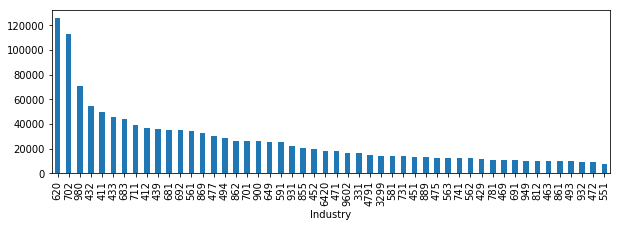

In [51]:
plot_frequency(wdf, 'Industry')

AVG:  4464.291316526611


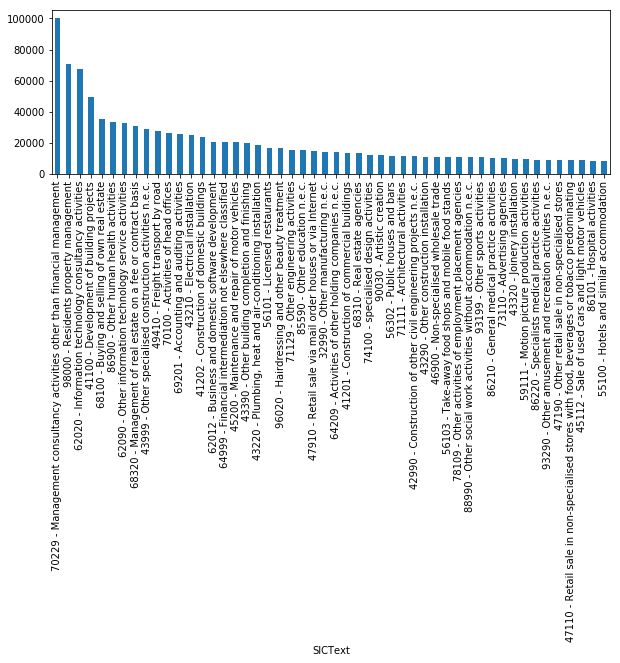

In [52]:
plot_frequency(wdf, 'SICText')

In [53]:
def resample_classes(df, groupby, samples):
    classes = wdf.groupby([groupby]).CompanyName.count()
    freqs = dict(samples/classes)
    freq = df[groupby].map(freqs)
    np.random.seed(42)
    criteria = np.random.rand(len(df)) < freq
    return df[criteria]

In [75]:
rwdf = resample_classes(wdf, 'Industry', 6500)

AVG:  5417.851851851852


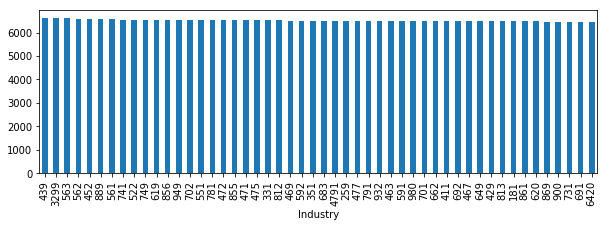

In [76]:
plot_frequency(rwdf, 'Industry')

AVG:  1652.90395480226


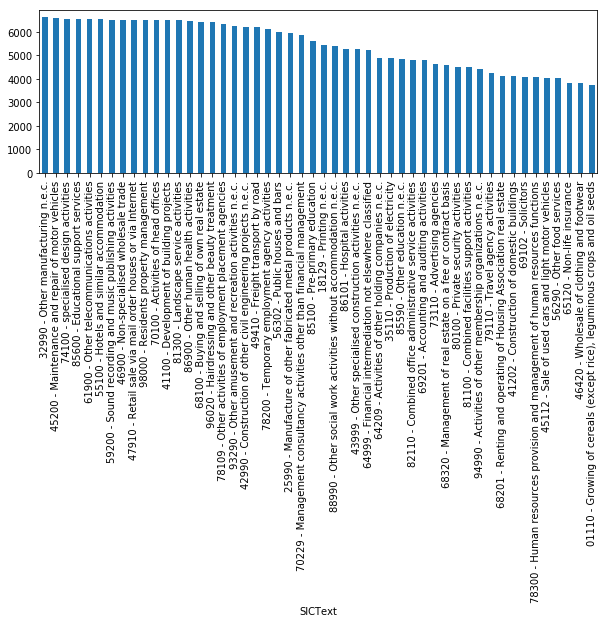

In [77]:
plot_frequency(rwdf, 'SICText')

### Pickle Working Set

In [71]:
feather.write_dataframe(wdf, 'wdf4m-no-num-nec.feather')

In [6]:
wdf = feather.read_dataframe('wdf4m-no-num-nec.feather')
wdf.head()

,CompanyName,SICC,WordSum,Industry,SICText,OrigIndustry
0,!NVERTD DESIGNS,58190,5089,581,58190 - Other publishing activities,581
1,!OBAC UK,70229,2046,702,70229 - Management consultancy activities othe...,702
2,!YOZO FASS,90010,349123,900,90010 - Performing arts,900
3,243 RUGBY ROAD MANAGEMENT COMPANY,98000,4265,980,98000 - Residents property management,980
4,309 WEST END LANE MANAGEMENT,98000,5476,980,98000 - Residents property management,980


### Label Encoding

In [78]:
industry_encoder = LabelEncoder()
industry_encoder.fit(rwdf['Industry'])
encoded_industry = industry_encoder.transform(rwdf['Industry'])
industry_labels = np_utils.to_categorical(encoded_industry)
industry_labels.shape

(585128, 108)

In [79]:
num_industries = industry_labels.shape[1]

### Text Encoding

In [20]:
def load_glove_embeddings(fp, embedding_dim, include_empty_char=True):
    """
    Loads pre-trained word embeddings (GloVe embeddings)
        Inputs: - fp: filepath of pre-trained glove embeddings
                - embedding_dim: dimension of each vector embedding
                - generate_matrix: whether to generate an embedding matrix
        Outputs:
                - word2coefs: Dictionary. Word to its corresponding coefficients
                - word2index: Dictionary. Word to word-index
                - embedding_matrix: Embedding matrix for Keras Embedding layer
    """
    # First, build the "word2coefs" and "word2index"
    word2coefs = {} # word to its corresponding coefficients
    word2index = {} # word to word-index
    with open(fp) as f:
        for idx, line in enumerate(f):
            try:
                data = [x.strip().lower() for x in line.split()]
                word = data[0]
                coefs = np.asarray(data[1:embedding_dim+1], dtype='float32')
                word2coefs[word] = coefs
                if word not in word2index:
                    word2index[word] = len(word2index)
            except Exception as e:
                print('Exception occurred in `load_glove_embeddings`:', e)
                continue
        # End of for loop.
    # End of with open
    if include_empty_char:
        word2index[''] = len(word2index)
    # Second, build the "embedding_matrix"
    # Words not found in embedding index will be all-zeros. Hence, the "+1".
    vocab_size = len(word2coefs)+1 if include_empty_char else len(word2coefs)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in word2index.items():
        embedding_vec = word2coefs.get(word)
        if embedding_vec is not None and embedding_vec.shape[0]==embedding_dim:
            embedding_matrix[idx] = np.asarray(embedding_vec)
    # return word2coefs, word2index, embedding_matrix
    return word2index, np.asarray(embedding_matrix)

In [21]:
word2index, embedding_matrix = load_glove_embeddings('glove.6B/glove.6B.100d.txt', embedding_dim=100)

In [22]:
def custom_tokenize(d):
    return [word2index.get(re.sub(r'[^\w\s]','',w).lower(), 0) for w in d.split()]

In [23]:
def sum_of_custom_tokenize(d):
    return sum(word2index.get(re.sub(r'[^\w\s]','',w).lower(), 0) for w in d.split())

In [24]:
vocab_size, embedding_dim = embedding_matrix.shape
maxlen = 10
print(custom_tokenize('This is an apple inc 10'))
print(custom_tokenize('what is this, an apple ltd?'))
vocab_size, embedding_dim

[37, 14, 29, 3292, 15231, 206]
[102, 14, 37, 29, 3292, 8196]


(400001, 100)

In [80]:
encoded_company_names = [custom_tokenize(d) for d in rwdf.CompanyName]
encoded_company_names = [d for d in encoded_company_names]
encoded_company_names = pad_sequences(encoded_company_names, maxlen=maxlen, padding='post')

In [81]:
# Sanity check
len(encoded_company_names), len(industry_labels)

(585128, 585128)

### Train/Test Split

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    encoded_company_names, industry_labels, test_size=0.18, random_state=42)
y_train.shape

(479804, 108)

### Model

In [85]:
weight_decay = 1e-4
num_filters = 256
n2 = 128
pool_size = 2
window_size = 3
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen,
                            weights=[embedding_matrix], trainable=False)
model = Sequential()
model.add(embedding_layer)
model.add(Convolution1D(num_filters, window_size, activation='relu', padding='same'))
#model.add(MaxPooling1D(pool_size))
model.add(Convolution1D(num_filters, window_size, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(n2, activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(Dense(num_industries, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 10, 100)           40000100  
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 10, 256)           77056     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 10, 256)           196864    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 108)               13932     
Total para

### ROC AUC Metric

In [29]:
class ROCCallback(Callback):
    def __init__(self,training_data,validation_data):
        self.x, self.y = training_data
        self.x_val, self.y_val = validation_data

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

### Hook up Tensorboard

`tensorboard --logdir='tmp'`

In [86]:
date_suffix = str(datetime.now()).replace(':', '-').split('.')[0]
temp_folder = 'tmp/GloVe%s-fd%s-industry-resmpl-cnn2x%s-dense%s-gpool-nnec-%s' % (
    embedding_dim, num_industries, num_filters, n2, date_suffix)
temp_folder

'tmp/GloVe100-fd108-industry-resmpl-cnn2x256-dense128-gpool-nnec-2018-03-23 15-29-32'

### Train Model

In [87]:
callbacks = [TensorBoard(log_dir=temp_folder)]
#callbacks.append(ROCCallback((X_train, y_train), (X_test, y_test)))
model.fit(
    X_train, y_train, epochs=18, batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=callbacks)

Train on 479804 samples, validate on 105324 samples
Epoch 1/18
479804/479804 [==============================] - 123s 256us/step - loss: 3.1910 - acc: 0.2563 - val_loss: 2.9241 - val_acc: 0.3096
Epoch 2/18
479804/479804 [==============================] - 122s 254us/step - loss: 2.9662 - acc: 0.3006 - val_loss: 2.8607 - val_acc: 0.3197
Epoch 3/18
479804/479804 [==============================] - 123s 256us/step - loss: 2.9141 - acc: 0.3099 - val_loss: 2.8513 - val_acc: 0.3233
Epoch 4/18
479804/479804 [==============================] - 123s 256us/step - loss: 2.8825 - acc: 0.3156 - val_loss: 2.8361 - val_acc: 0.3281
Epoch 5/18
479804/479804 [==============================] - 122s 254us/step - loss: 2.8614 - acc: 0.3198 - val_loss: 2.8274 - val_acc: 0.3296
Epoch 6/18
479804/479804 [==============================] - 123s 256us/step - loss: 2.8474 - acc: 0.3222 - val_loss: 2.8389 - val_acc: 0.3285
Epoch 7/18
479804/479804 [==============================] - 123s 255us/step - loss: 2.8328 - acc

KeyboardInterrupt: 

### Testing/Validation

In [88]:
loss, accuracy = model.evaluate(X_test, y_test)
accuracy

105324/105324 [==============================] - 9s 86us/step


0.33424480650240784

In [89]:
y_labels = np.argmax(y_test, axis=1)
y_pred = model.predict_classes(X_test)
y_labels.shape, y_pred.shape
y_scores = model.predict(X_test)
cm = confusion_matrix(y_pred, y_labels)

In [90]:
print('Verifying accuracy', (y_labels==y_pred).sum()/len(y_pred))

Verifying accuracy 0.334244806502


In [91]:
def plot_confusion_matrix(cm, encoder):
    pylab.figure(figsize=(10,10))
    cm = cm/cm.sum(axis=0)
    dim, _ =cm.shape
    pylab.matshow(cm, fignum=False, cmap='Blues', vmin=0, vmax=0.5)
    ax = pylab.gca()
    ax.set_xticks(range(dim))
    ax.set_xticklabels(encoder.inverse_transform(pd.Series(range(dim))), rotation='vertical')
    ax.set_yticks(range(dim))
    ax.set_yticklabels(encoder.inverse_transform(pd.Series(range(dim))))
    pylab.colorbar()
    pylab.grid(False)
    pylab.xlabel('Predicted')
    pylab.ylabel('Actual')
    pylab.show()

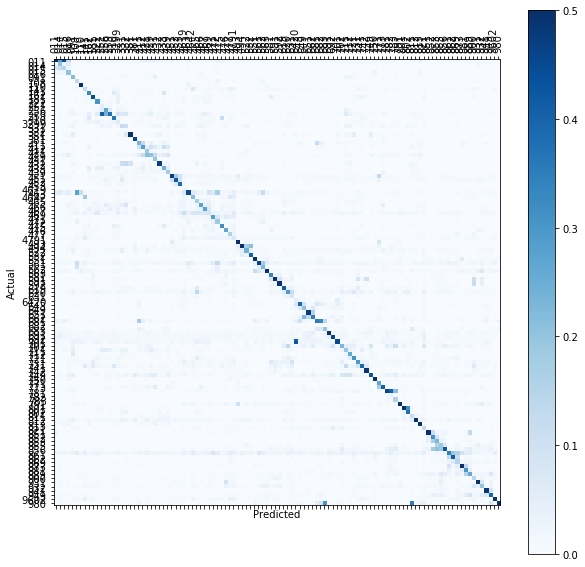

In [92]:
plot_confusion_matrix(cm, industry_encoder)

In [93]:
def acc_per_class(cm, encoder):
    cm_scaled = cm/cm.sum(axis=0)
    acc = pd.Series(np.diag(cm_scaled))
    acc = acc.reset_index()
    acc['acc'] = acc[0]
    acc['class'] = encoder.inverse_transform(acc.index)
    acc['total'] = cm.sum(axis=0)
    return acc[['class', 'acc', 'total']].set_index('class').sort_values('acc', ascending=False)

In [94]:
acc_per_class(cm, industry_encoder)

,acc,total
class,,
980,0.866435,1153
851,0.691634,1028
791,0.663907,1208
351,0.647708,1178
9602,0.641003,1117
110,0.595349,430
494,0.594178,1168
812,0.586383,1175
750,0.569811,530


### ROC Evaluation

In [141]:
def plot_roc(y_test, y_score, encoder):
    # Compute ROC curve and area for each class
    print('ROC AUC Score: %s' % roc_auc_score(y_test, y_score))
    lw = 2
    n_classes = y_test.shape[1]
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, ax = pylab.subplots()
    fig.set_figwidth(12)
    fig.set_figheight(8)
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'crimson', 'navy',
                    'darksalmon', 'cadetblue', 'deeppink', 'darkolivegreen', 'fuchsia'])
    sorted_classes = sorted(range(n_classes), key=lambda i: roc_auc[i])
    for i, color in zip(sorted_classes, colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(encoder.inverse_transform(i), roc_auc[i]))
    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    pylab.xlim([0.0, 1.0])
    pylab.ylim([0.0, 1.05])
    pylab.xlabel('False Positive Rate')
    pylab.ylabel('True Positive Rate')
    ax.legend(loc="lower left", bbox_to_anchor=(0.0, 1.01), ncol=4, frameon=False)
    pylab.show()

ROC AUC Score: 0.88350295458


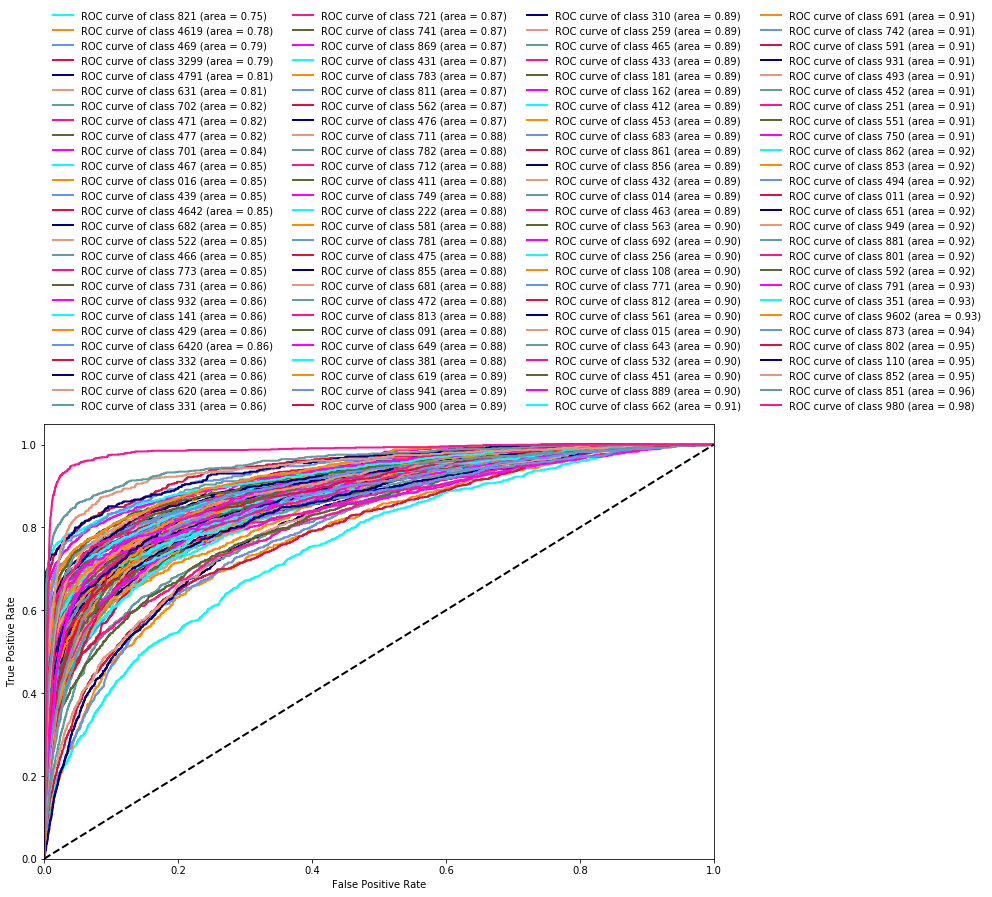

In [142]:
plot_roc(y_test, y_scores, industry_encoder)

### Test with Original Sampling

In [83]:
industry_encoder = LabelEncoder()
industry_encoder.fit(wdf['Industry'])
encoded_industry = industry_encoder.transform(wdf['Industry'])
industry_labels = np_utils.to_categorical(encoded_industry)
industry_labels.shape

(1990801, 114)

In [ ]:
encoded_company_names = [custom_tokenize(d) for d in wdf.CompanyName]
encoded_company_names = [d for d in encoded_company_names]
encoded_company_names = pad_sequences(encoded_company_names, maxlen=maxlen, padding='post')

In [ ]:
# Sanity check
len(encoded_company_names), len(industry_labels)

In [ ]:
loss, accuracy = model.evaluate(encoded_company_names, industry_labels)
accuracy

In [ ]:
y_labels = np.argmax(y_test, axis=1)
y_pred = model.predict_classes(X_test)
y_labels.shape, y_pred.shape
cm = confusion_matrix(y_pred, y_labels)

In [ ]:
plot_confusion_matrix(cm, [])

In [ ]:
acc_per_class(cm, industry_encoder)

### Save Model

In [39]:
model_output = 'models/%s-acc%0.4f.h5' % ('Trial10-GloVe100-Stacked-4m-CNN-Pooled-No-NEC', accuracy)
model.save(model_output)
model_output

### Play with Model

In [40]:
SIC_df = pd.read_csv('SIC07_CH_condensed_list_en.csv', dtype={'SIC Code': 'object'})

In [41]:
def pretext(precode):
    return '\n'.join('\t\t%s\t%s' % (value['SIC Code'], value.Description[:90]) 
                     for i, value in SIC_df[SIC_df['SIC Code'].str.startswith(precode)].iterrows())

In [ ]:
while True:
    name = input()
    if not name:
        break
    name = re.sub(r"[\-,'\"]", " ", name)
    encoded = custom_tokenize(name)
    if sum(encoded) == 0:
        print('\tWords in the input are not recognized.')
        continue
    encoded_company_name = pad_sequences([encoded], maxlen=maxlen, padding='post')
    pred = model.predict(encoded_company_name).flatten()
    probas = sorted(enumerate(pred), key=lambda x: x[1], reverse=True)[:3]
    total = sum(pred)
    if max(pred)/total < 0.1:
        print('\tNo classification exceeds 10% likelihood.')
        continue
    for i, p in probas:
        code = industry_encoder.inverse_transform(i)
        print('\t%0.2f%%' % (p/total*100))
        print(pretext(code))

t-mobile
	53.12%
		61900	Other telecommunications activities
	13.61%
		46510	Wholesale of computers, computer peripheral equipment and software
		46520	Wholesale of electronic and telecommunications equipment and parts
	3.27%
		73110	Advertising agencies
		73120	Media representation services
wind mobile
	24.19%
		35110	Production of electricity
		35120	Transmission of electricity
		35130	Distribution of electricity
		35140	Trade of electricity
	19.13%
		61900	Other telecommunications activities
	4.92%
		46510	Wholesale of computers, computer peripheral equipment and software
		46520	Wholesale of electronic and telecommunications equipment and parts
google
	26.82%
		62011	Ready-made interactive leisure and entertainment software development
		62012	Business and domestic software development
		62020	Information technology consultancy activities
		62030	Computer facilities management activities
		62090	Other information technology service activities
	17.91%
		63110	Data processing, hostin

Lloyds Banking Group
	39.27%
		70100	Activities of head offices
	38.79%
		64201	Activities of agricultural holding companies
		64202	Activities of production holding companies
		64203	Activities of construction holding companies
		64204	Activities of distribution holding companies
		64205	Activities of financial services holding companies
		64209	Activities of other holding companies n.e.c.
	3.43%
		66210	Risk and damage evaluation
		66220	Activities of insurance agents and brokers
		66290	Other activities auxiliary to insurance and pension funding
Vodafone Group
	31.02%
		70100	Activities of head offices
	30.26%
		64201	Activities of agricultural holding companies
		64202	Activities of production holding companies
		64203	Activities of construction holding companies
		64204	Activities of distribution holding companies
		64205	Activities of financial services holding companies
		64209	Activities of other holding companies n.e.c.
	21.55%
		61900	Other telecommunications activities
Exxon